In [1]:
import numpy as np
import pandas as pd
import torch 
import os
import torch.nn as nn
import torchvision.transforms as T
import torch.utils.data as data
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from PIL import Image
from torchvision.utils import save_image
from torchvision.utils import make_grid

In [2]:
!pip install torchsummary

In [3]:
from torchsummary import summary

In [4]:
DATA_DIR = '../input/anime-sketch-colorization-pair/data'
batch_size = 64
image_size = 128
latent_size = 100
stats = (0.5,0.5,0.5),(0.5,0.5,0.5)

In [5]:
class CustomImageDataset(data.Dataset):
    def __init__(self,image_dir,subfolder='train',transform=None):
        super().__init__()
        self.input_path = os.path.join(image_dir,subfolder)
        self.transform = transform
        self.images_filenames = [x for x in os.listdir(self.input_path)]
    
    def __getitem__(self,index):
        img_fn = os.path.join(self.input_path,self.images_filenames[index])
        img = Image.open(img_fn).convert('RGB')
        img = self.transform(img)
        img = img[:,:,0:image_size]
        return img
    
    def __len__(self):
        return len(self.images_filenames)
    

In [6]:
transform = T.Compose([
    T.Resize(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
])

In [7]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [8]:
train_ds = CustomImageDataset(DATA_DIR,'train',transform)
train_dl = DataLoader(train_ds,batch_size,drop_last=True,shuffle=True)

In [9]:
for i in train_ds:
    print(i.shape)
    break

torch.Size([3, 128, 128])


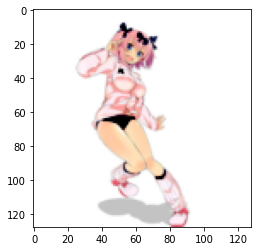

In [10]:
for i  in train_dl:
    plt.imshow(i[0].permute(1,2,0))
    break

In [11]:
def show_images(images,nmax=64):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
    for images in dl:
        show_images(images,nmax)
        break;

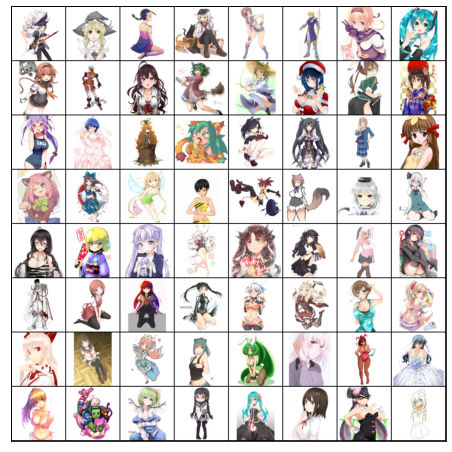

In [12]:
show_batch(train_dl)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
device

'cuda'

In [15]:
def to_device(data,device):
    if(isinstance(data,(list,tuple))):
        return [ to_device(x,device) for x in data]
    return data.to(device)

class DeviceDataLoader():
    def __init__(self,dl,device) -> None:
        self.dl = dl 
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)

    def __len__(self):
        return len(self.dl)            

In [16]:
train_dl = DeviceDataLoader(train_dl,device)

In [17]:
discriminator = nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),
    
    nn.Conv2d(512,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)

In [18]:
if device=='cuda': discriminator.to(device)

In [19]:
generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size,1024,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh()
)

In [20]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [21]:
generator.apply(weights_init)
discriminator.apply(weights_init)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [22]:
if device=='cuda': generator.to(device)

In [23]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002,betas=(0.5,0.999))

In [24]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [25]:
def train_discriminator(images):
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)

    outputs = discriminator(images)
    d_loss_real = criterion(outputs,real_labels)
    real_score = outputs.mean().item()

    z = torch.randn(batch_size,latent_size,1,1).to(device)
    fake_images = generator(z)
    outputs = discriminator(fake_images)
    d_loss_fake = criterion(outputs,fake_labels)
    fake_score = outputs.mean().item()

    d_loss = d_loss_real+d_loss_fake

    reset_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item(), real_score, fake_score

In [26]:
def train_generator():
    z = torch.randn(batch_size,latent_size,1,1).to(device)
    fake_images = generator(z)
    labels = torch.ones(batch_size,1).to(device)
    g_loss = criterion(discriminator(fake_images),labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()


In [27]:
fixed_latent = torch.randn(batch_size,latent_size,1,1,device=device)

In [28]:
sample_dir = 'generated'
os.makedirs(sample_dir,exist_ok=True)

In [29]:
def save_samples(index,latent_tensors):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated_images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving Image',fake_fname)

In [30]:
def gen_image():
    lt = torch.randn(batch_size,latent_size,1,1,device=device)
    a = generator(lt)
    a = a.cpu().detach()
    plt.imshow(a[0].permute(1,2,0))
    plt.plot()

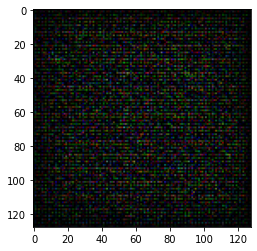

In [31]:
gen_image()

In [32]:
num_epochs = 50
total_step = len(train_dl)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i,images in enumerate(train_dl):
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss = train_generator()
        
        if(i%5==0):
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            real_scores.append(real_score)
            fake_scores.append(fake_score)
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss, g_loss, 
                          real_score, fake_score))
            
    save_samples(epoch+1,fixed_latent)
            

Epoch [0/50], Step [1/222], d_loss: 1.4905, g_loss: 9.4345, D(x): 0.74, D(G(z)): 0.60
Epoch [0/50], Step [6/222], d_loss: 0.2556, g_loss: 10.0610, D(x): 0.87, D(G(z)): 0.01
Epoch [0/50], Step [11/222], d_loss: 0.4944, g_loss: 22.8185, D(x): 0.76, D(G(z)): 0.00
Epoch [0/50], Step [16/222], d_loss: 0.4925, g_loss: 18.7808, D(x): 0.80, D(G(z)): 0.00
Epoch [0/50], Step [21/222], d_loss: 0.0012, g_loss: 12.9944, D(x): 1.00, D(G(z)): 0.00
Epoch [0/50], Step [26/222], d_loss: 9.6233, g_loss: 27.4639, D(x): 0.97, D(G(z)): 1.00
Epoch [0/50], Step [31/222], d_loss: 0.4089, g_loss: 27.9353, D(x): 0.87, D(G(z)): 0.00
Epoch [0/50], Step [36/222], d_loss: 4.5710, g_loss: 30.6865, D(x): 0.08, D(G(z)): 0.00
Epoch [0/50], Step [41/222], d_loss: 11.9714, g_loss: 19.3708, D(x): 1.00, D(G(z)): 1.00
Epoch [0/50], Step [46/222], d_loss: 0.7684, g_loss: 19.8151, D(x): 0.64, D(G(z)): 0.00
Epoch [0/50], Step [51/222], d_loss: 0.6679, g_loss: 13.7293, D(x): 0.90, D(G(z)): 0.29
Epoch [0/50], Step [56/222], d_los

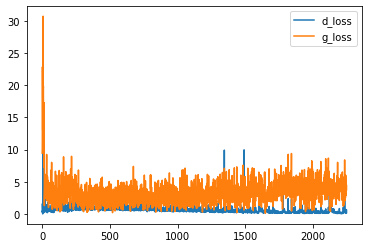

In [33]:
plt.plot(d_losses,label='d_loss')
plt.plot(g_losses,label='g_loss')
plt.legend()

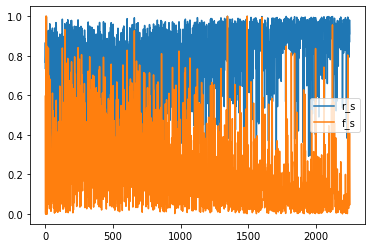

In [34]:
plt.plot(real_scores,label='r_s')
plt.plot(fake_scores,label='f_s')
plt.legend()

In [35]:
# Image.open('generated/generated_images-0149.png')